In [1]:
import iohinspector
import polars as pl
from iohblade.behaviour_metrics import compute_behavior_metrics
from tqdm import tqdm
import pandas as pd
import numpy as np
from iohblade.loggers import ExperimentLogger
from iohblade import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os

"""
    mutation_prompts1 = [
        "Refine and simplify the selected algorithm to improve it.",  # simplify mutation
    ]
    mutation_prompts2 = [
        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution
    ]
    mutation_prompts3 = [
        "Refine and simplify the selected solution to improve it.",  # simplify mutation
        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution
    ]
    LLaMEA_method1 = LLaMEA(llm, budget=budget, name=f"LLaMEA-1", mutation_prompts=mutation_prompts1, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method2 = LLaMEA(llm, budget=budget, name=f"LLaMEA-2", mutation_prompts=mutation_prompts2, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method3 = LLaMEA(llm, budget=budget, name=f"LLaMEA-3", mutation_prompts=mutation_prompts3, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method4 = LLaMEA(llm, budget=budget, name=f"LLaMEA-4", mutation_prompts=mutation_prompts3, n_parents=1, n_offspring=1, elitism=True) 
    LLaMEA_method5 = LLaMEA(llm, budget=budget, name=f"LLaMEA-5", mutation_prompts=None, adaptive_mutation=True, n_parents=4, n_offspring=12, elitism=False) 
    LLaMEA_method6 = LLaMEA(llm, budget=budget, name=f"LLaMEA-6", mutation_prompts=None, adaptive_mutation=True, n_parents=1, n_offspring=1, elitism=True) 
# """

# | **Metric**                              | **What it Measures**                                    | **Reference**                          |
# | --------------------------------------- | ------------------------------------------------------- | -------------------------------------- |
# | **Nearest-Neighbor Distance** (avg NND) | Novelty of new samples (exploration)                    | Distance-based exploration     https://arxiv.org/html/2410.14573#:~:text=removing%20points%20from%20the%20Pareto,various%20optimization%20scenarios%20and%20objectives        |
# | **Coverage / Dispersion**               | Fraction of space covered (exploration)                 | Space-filling designs in DOE   https://www.nature.com/articles/s41598-024-68436-1#:~:text=To%20perform%20population%20diversity%20analysis%2C,used%20for%20population%20diversity%20estimation        |
# | **Spatial Entropy**                     | Spread/uncertainty of sample distribution               | Entropy for batch diversity    https://www.nature.com/articles/s41598-024-68436-1#:~:text=To%20perform%20population%20diversity%20analysis%2C,used%20for%20population%20diversity%20estimation        |
# | **Proximity to Best**                   | Focus on known optima (exploitation)                    | Exploitation = staying in neighborhood https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=space,regions%20of%20a%20search%20space  |
# | **Exploration–Exploitation %**          | Trade-off via diversity (time-varying)                  | Pop. diversity ratio                 https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac |
# | **Success/Improvement Rate**            | Frequency of improving moves (convergence/exploitation) | 1/5th success rule concept           https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac  |
# | **Area Under Conv. Curve**              | Overall speed of convergence                            | – (common in benchmarking)             |
# | **Average Convergence Rate** (ACR)      | Geometric mean error reduction (convergence speed)      | Convergence rate analysis             https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac |
# | **No-Improvement Streak**               | Longest stagnation period                               | Used as stopping criterion            https://www.sciencedirect.com/science/article/pii/S037722172200159X#:~:text=The%20second%20parameter%20to%20be,In%20this%20case%2C%20we |
# | **Last Improvement Fraction**           | Portion of run spent stagnating                         | – (derived from convergence curve)     |
# | **Pop. Diversity (to centroid)**        | Dispersion of points in search space                    | “Distance to average” measure         https://www.sciencedirect.com/science/article/pii/S037722172200159X#:~:text=The%20second%20parameter%20to%20be,In%20this%20case%2C%20we |
# | **Mean Pairwise Distance**              | Overall pairwise diversity                              | Diversity measures in EAs             https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=match%20at%20L885%20%E2%80%94Distance,used%20type%20of%20diversity%20measure |
# | **Coverage Volume**                     | Volume spanned by samples (diversity)                   | DPP-based diversity                   https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=match%20at%20L885%20%E2%80%94Distance,used%20type%20of%20diversity%20measure |
# | **Average Step Length**                 | Typical move size (exploration intensity)               | Step size reduction in search         https://stats.stackexchange.com/questions/304813/stopping-criterion-for-nelder-mead#:~:text=Stopping%20criterion%20for%20Nelder%20Mead,than%20some%20tolerance%20TOL |
# | **Total Path Length**                   | Total distance traveled                                 | – (trajectory length analysis)         |
# | **Path Efficiency**                     | Directness of search path                               | –                                      |
# | **Step Length Trend**                   | Change of step size over time (convergence indicator)   | – (implied by 1/5th rule)              |


Failed to update token costs. Using static costs.
/home/neocortex/.cache/pypoetry/virtualenvs/iohblade-xXF9vABH-py3.10/lib/python3.10/site-packages/tokencost/constants.py:69: RuntimeWarning: coroutine 'update_token_costs' was never awaited
  logger.error("Failed to update token costs. Using static costs.")


'\n    mutation_prompts1 = [\n        "Refine and simplify the selected algorithm to improve it.",  # simplify mutation\n    ]\n    mutation_prompts2 = [\n        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution\n    ]\n    mutation_prompts3 = [\n        "Refine and simplify the selected solution to improve it.",  # simplify mutation\n        "Generate a new algorithm that is different from the algorithms you have tried before.", #new random solution\n    ]\n    LLaMEA_method1 = LLaMEA(llm, budget=budget, name=f"LLaMEA-1", mutation_prompts=mutation_prompts1, n_parents=4, n_offspring=12, elitism=False) \n    LLaMEA_method2 = LLaMEA(llm, budget=budget, name=f"LLaMEA-2", mutation_prompts=mutation_prompts2, n_parents=4, n_offspring=12, elitism=False) \n    LLaMEA_method3 = LLaMEA(llm, budget=budget, name=f"LLaMEA-3", mutation_prompts=mutation_prompts3, n_parents=4, n_offspring=12, elitism=False) \n    LLaMEA_method4 = LLaMEA(llm,

| **Metric**                              | **What it Measures**                                    | **Reference**                          |
| --------------------------------------- | ------------------------------------------------------- | -------------------------------------- |
| **Nearest-Neighbor Distance** (avg NND) | Novelty of new samples (exploration)                    | Distance-based exploration     https://arxiv.org/html/2410.14573#:~:text=removing%20points%20from%20the%20Pareto,various%20optimization%20scenarios%20and%20objectives        |
| **Coverage / Dispersion**               | Fraction of space covered (exploration)                 | Space-filling designs in DOE   https://www.nature.com/articles/s41598-024-68436-1#:~:text=To%20perform%20population%20diversity%20analysis%2C,used%20for%20population%20diversity%20estimation        |
| **Spatial Entropy**                     | Spread/uncertainty of sample distribution               | Entropy for batch diversity    https://www.nature.com/articles/s41598-024-68436-1#:~:text=To%20perform%20population%20diversity%20analysis%2C,used%20for%20population%20diversity%20estimation        |
| **Proximity to Best**                   | Focus on known optima (exploitation)                    | Exploitation = staying in neighborhood https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=space,regions%20of%20a%20search%20space  |
| **Exploration–Exploitation %**          | Trade-off via diversity (time-varying)                  | Pop. diversity ratio                 https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac |
| **Success/Improvement Rate**            | Frequency of improving moves (convergence/exploitation) | 1/5th success rule concept           https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac  |           |
| **Average Convergence Rate** (ACR)      | Geometric mean error reduction (convergence speed)      | Convergence rate analysis             https://www.nature.com/articles/s41598-024-68436-1#:~:text=%24%24exploration%5C%3B%5Cleft%28iteration%5Cright%29%3D%5Cleft%28%5Cfrac |
| **No-Improvement Streak**               | Longest stagnation period                               | Used as stopping criterion            https://www.sciencedirect.com/science/article/pii/S037722172200159X#:~:text=The%20second%20parameter%20to%20be,In%20this%20case%2C%20we |
| **Last Improvement Fraction**           | Portion of run spent stagnating                         | – (derived from convergence curve)     |
| **Pop. Diversity (to centroid)**        | Dispersion of points in search space                    | “Distance to average” measure         https://www.sciencedirect.com/science/article/pii/S037722172200159X#:~:text=The%20second%20parameter%20to%20be,In%20this%20case%2C%20we |
| **Mean Pairwise Distance**              | Overall pairwise diversity                              | Diversity measures in EAs             https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=match%20at%20L885%20%E2%80%94Distance,used%20type%20of%20diversity%20measure |
| **Coverage Volume**                     | Volume spanned by samples (diversity)                   | DPP-based diversity                   https://romisatriawahono.net/lecture/rm/survey/softcomputing/Crepinsek%20-%20Exploration%20and%20Exploitation%20in%20Evolutionary%20Algorithms%20-%202013.pdf#:~:text=match%20at%20L885%20%E2%80%94Distance,used%20type%20of%20diversity%20measure |
| **Average Step Length**                 | Typical move size (exploration intensity)               | Step size reduction in search         https://stats.stackexchange.com/questions/304813/stopping-criterion-for-nelder-mead#:~:text=Stopping%20criterion%20for%20Nelder%20Mead,than%20some%20tolerance%20TOL |



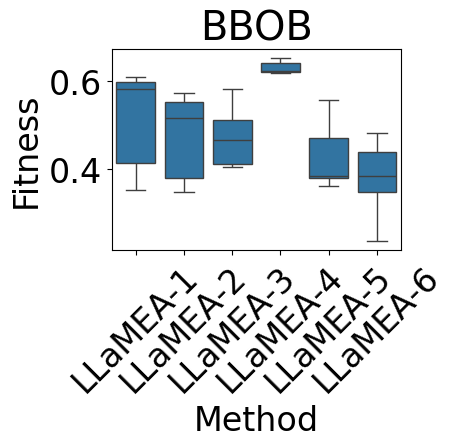

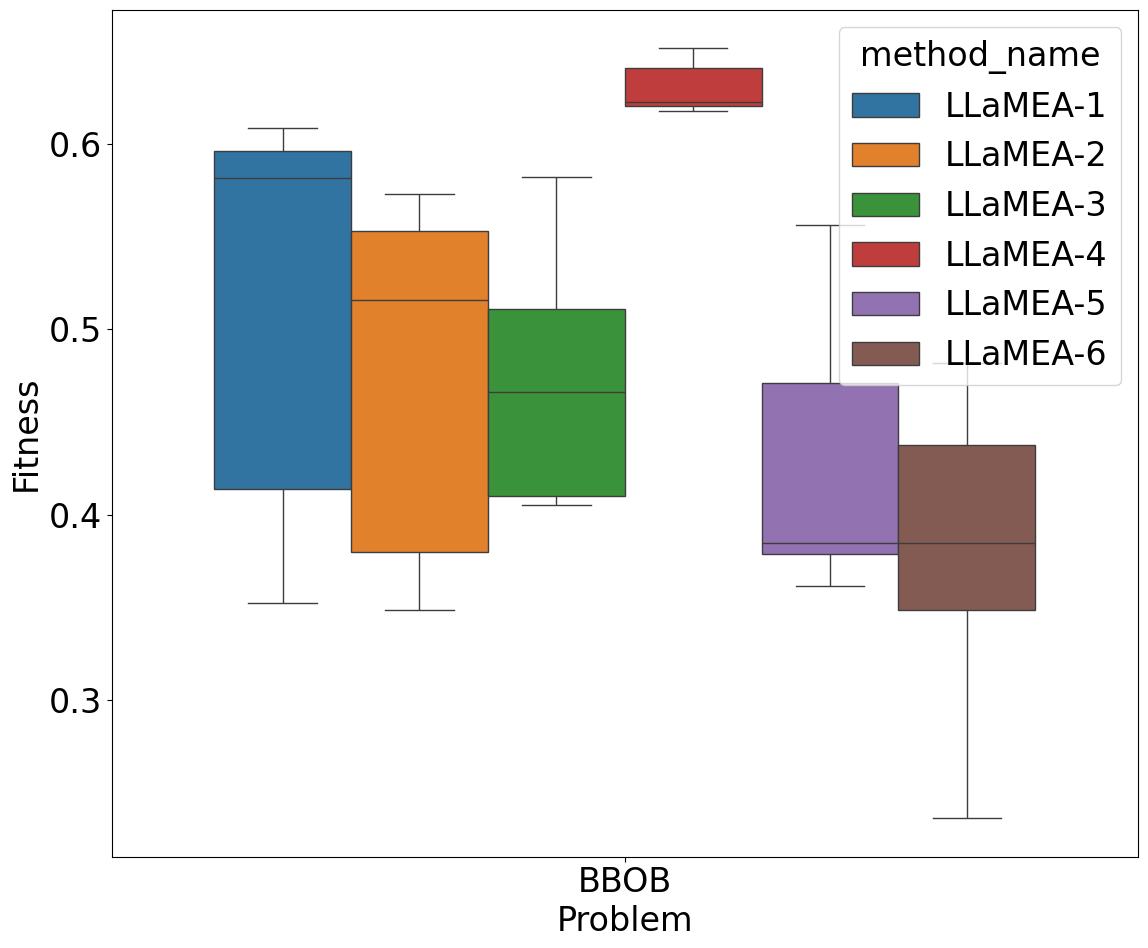

In [2]:
logger = ExperimentLogger('/data/neocortex/BBOB-2', True)

plot_convergence(logger, metric="AOCC", save=True, budget=100)
#plot_experiment_CEG(logger, save=True, budget=100, max_seeds=5)

plot_boxplot_fitness(logger)
plot_boxplot_fitness_hue(logger)

In [ ]:

## THIS CODE IS INSIDE process_bbob_runs.py now
# logger = ExperimentLogger('/data/neocortex/BBOB', True)

# data = logger.get_data()


# tqdm.pandas(desc="Processing runs")

# func_ids        = [1, 3, 6, 8, 10, 13, 15, 17, 21, 23]
# runs_per_func   = 5          # we know each function has 5 runs

# def avg_auc_for_fid(aucs: list[float], fid: int, runs_per_func=5, func_ids=[1, 3, 6, 8, 10, 13, 15, 17, 21, 23]) -> float:
#     """
#     aucs = 50-long list in metadata.
#     Take the five entries belonging to the requested fid and average them.
#     """
#     if len(aucs) < 50:
#         return 0
#     block = func_ids.index(fid) * runs_per_func
#     slice_ = aucs[block : block + runs_per_func]
#     return float(np.mean(slice_))

# def process_run(row, func_ids= [1, 3, 6, 8, 10, 13, 15, 17, 21, 23], runs_per_func=5, root="/data/neocortex/BBOB/ioh/"):
#     rows = []
#     # each algorithm has 50 different runs = 50 different directories we need to process
#     algid = row['id']
#     fitness = row['fitness']
#     aucs = row['aucs_list']

#     counter = 0
#     for fid in func_ids:
#         for run in range(runs_per_func):
            
#             path = f"{root}{algid}"
#             if counter > 0:
#                 path = f"{root}{algid}-{counter}"
#             # each algorithm has 50 different runs = 50 different directories we need to process
#             if not os.path.exists(path):
#                 continue
#             manager = iohinspector.DataManager()
#             manager.add_folder(path)
#             # load run data for one folder
#             df = manager.load(monotonic=False, include_meta_data=True)
#             metrics = compute_behavior_metrics(df)
#             counter += 1

#             f_fid = avg_auc_for_fid(aucs, fid, runs_per_func=runs_per_func, func_ids=func_ids)
#             metrics.update(
#                 {
#                     "id":           algid,
#                     "fid":          fid,
#                     "fitness_fid":  f_fid,
#                 }
#             )
#             rows.append(metrics)
#     return pd.DataFrame(rows)



# methods, problems = logger.get_methods_problems()
# print(methods)
# print(problems)

# df = logger.get_problem_data(problem_name='BBOB')

# def get_aucs(d):
#     """Return the list under key 'aucs' (or [] if anything is wrong)."""
#     try:
#         return d.get("aucs", [])
#     except (ValueError, SyntaxError):
#         return []

# df["aucs_list"] = df["metadata"].apply(get_aucs)


# frames = []

# for _, algo_row in tqdm(df.iterrows(),  # <‑‑ your dataframe of algorithms
#                         total=len(df),
#                         desc="algorithms"):
#     try:
#         df_runs = process_run(algo_row)      # your function above
#         frames.append(df_runs)
#     except Exception as e:
#         print(f"⚠︎  {algo_row['id']} skipped ({e})")

# all_runs = pd.concat(frames, ignore_index=True)

# print(f"✅  built dataframe with {len(all_runs)} runs")

# print(all_runs.columns)
# all_runs.to_pickle("./BBOB0.pkl")

In [9]:
#df.to_pickle("./BBOB0.pkl")
import pandas as pd
df = pd.read_pickle("../BBOB1.pkl")  
img_dir = "BBOB1/"
df.head()


,avg_nearest_neighbor_distance,dispersion,avg_exploration_pct,avg_distance_to_best,intensification_ratio,avg_exploitation_pct,average_convergence_rate,avg_improvement,success_rate,longest_no_improvement_streak,last_improvement_fraction,id,fid,fitness_fid,method_name,problem_name,seed,_id
0,0.069559,7.672290,2.551249,0.143603,0.960004,97.448751,0.996046,0.606228,0.005900,7244,0.724400,d08649de-99d5-482b-8266-764bc6004e31,1,0.908648,LLaMEA-1,BBOB,0,0
1,0.072521,8.775640,2.858334,0.156375,0.947905,97.141666,0.996046,0.394648,0.009000,6887,0.688700,d08649de-99d5-482b-8266-764bc6004e31,1,0.908648,LLaMEA-1,BBOB,0,0
2,0.066258,8.189909,2.478770,0.125152,0.962500,97.521230,0.995991,0.898358,0.006901,6922,0.692269,d08649de-99d5-482b-8266-764bc6004e31,1,0.908648,LLaMEA-1,BBOB,0,0
3,0.073151,8.843988,3.247767,0.167797,0.948805,96.752233,0.995935,1.503546,0.007200,7288,0.728800,d08649de-99d5-482b-8266-764bc6004e31,1,0.908648,LLaMEA-1,BBOB,0,0
4,0.069900,7.934380,2.495553,0.131425,0.963004,97.504447,0.996004,0.892225,0.006100,7605,0.760500,d08649de-99d5-482b-8266-764bc6004e31,1,0.908648,LLaMEA-1,BBOB,0,0


In [ ]:

behaviour_feats = [
        "avg_nearest_neighbor_distance", "dispersion", "avg_exploration_pct",
        "avg_distance_to_best", "intensification_ratio", "avg_exploitation_pct",
        "average_convergence_rate", "avg_improvement", "success_rate",
        "longest_no_improvement_streak", "last_improvement_fraction",
    ]

num_cols = df.select_dtypes('number').columns
agg_map  = {c: 'mean' for c in behaviour_feats} | {           # mean for numbers
                'id': 'first',                              # keep id constant
                'fitness_fid': 'mean',                     # average fitness per id
                'fid': 'first',                             
                '_id': 'first',
                'seed': 'first',
                'method_name': 'first',                    # keep one value
                'problem_name': 'first'}                   #  – they should be constant per id

df_all = (df
        .groupby('id', as_index=False)
        .agg(agg_map))

df_all.head()

,avg_nearest_neighbor_distance,dispersion,avg_exploration_pct,avg_distance_to_best,intensification_ratio,avg_exploitation_pct,average_convergence_rate,avg_improvement,success_rate,longest_no_improvement_streak,last_improvement_fraction,id,fid,_id,seed,method_name,problem_name
0,0.519930,5.480855,29.406810,2.422997,0.489160,70.593190,0.995661,41005.156441,0.004748,2469.28,0.179650,00476d3f-3db8-4c54-a3dd-3831d70ca923,1,22,0.0,LLaMEA-3,BBOB
1,0.216982,5.868765,42.573656,3.494892,0.306378,57.426344,0.995687,46659.792211,0.004014,2942.80,0.202914,005e1aed-7b5e-4be3-9c3d-00a68b73b3b0,1,26,1.0,LLaMEA-6,BBOB
2,0.355899,6.366471,15.868182,1.069148,0.657696,84.131818,0.995654,99545.665521,0.003516,2026.92,0.103152,0095fba8-24d2-40b7-a4b7-93d135de36a8,1,39,1.0,LLaMEA-5,BBOB
3,0.075744,8.290411,3.864202,0.214130,0.886810,96.135798,0.995660,1744.787202,0.054603,5113.76,0.491515,010ac146-2767-4533-bbd0-5a6cd1c0979d,1,76,2.0,LLaMEA-3,BBOB
4,0.365249,5.481832,19.199757,1.591039,0.700606,80.800243,0.995653,3756.050539,0.031271,3263.96,0.286354,010d3f1a-6ee9-4122-b624-1b023fc7c4c5,1,1,0.0,LLaMEA-2,BBOB


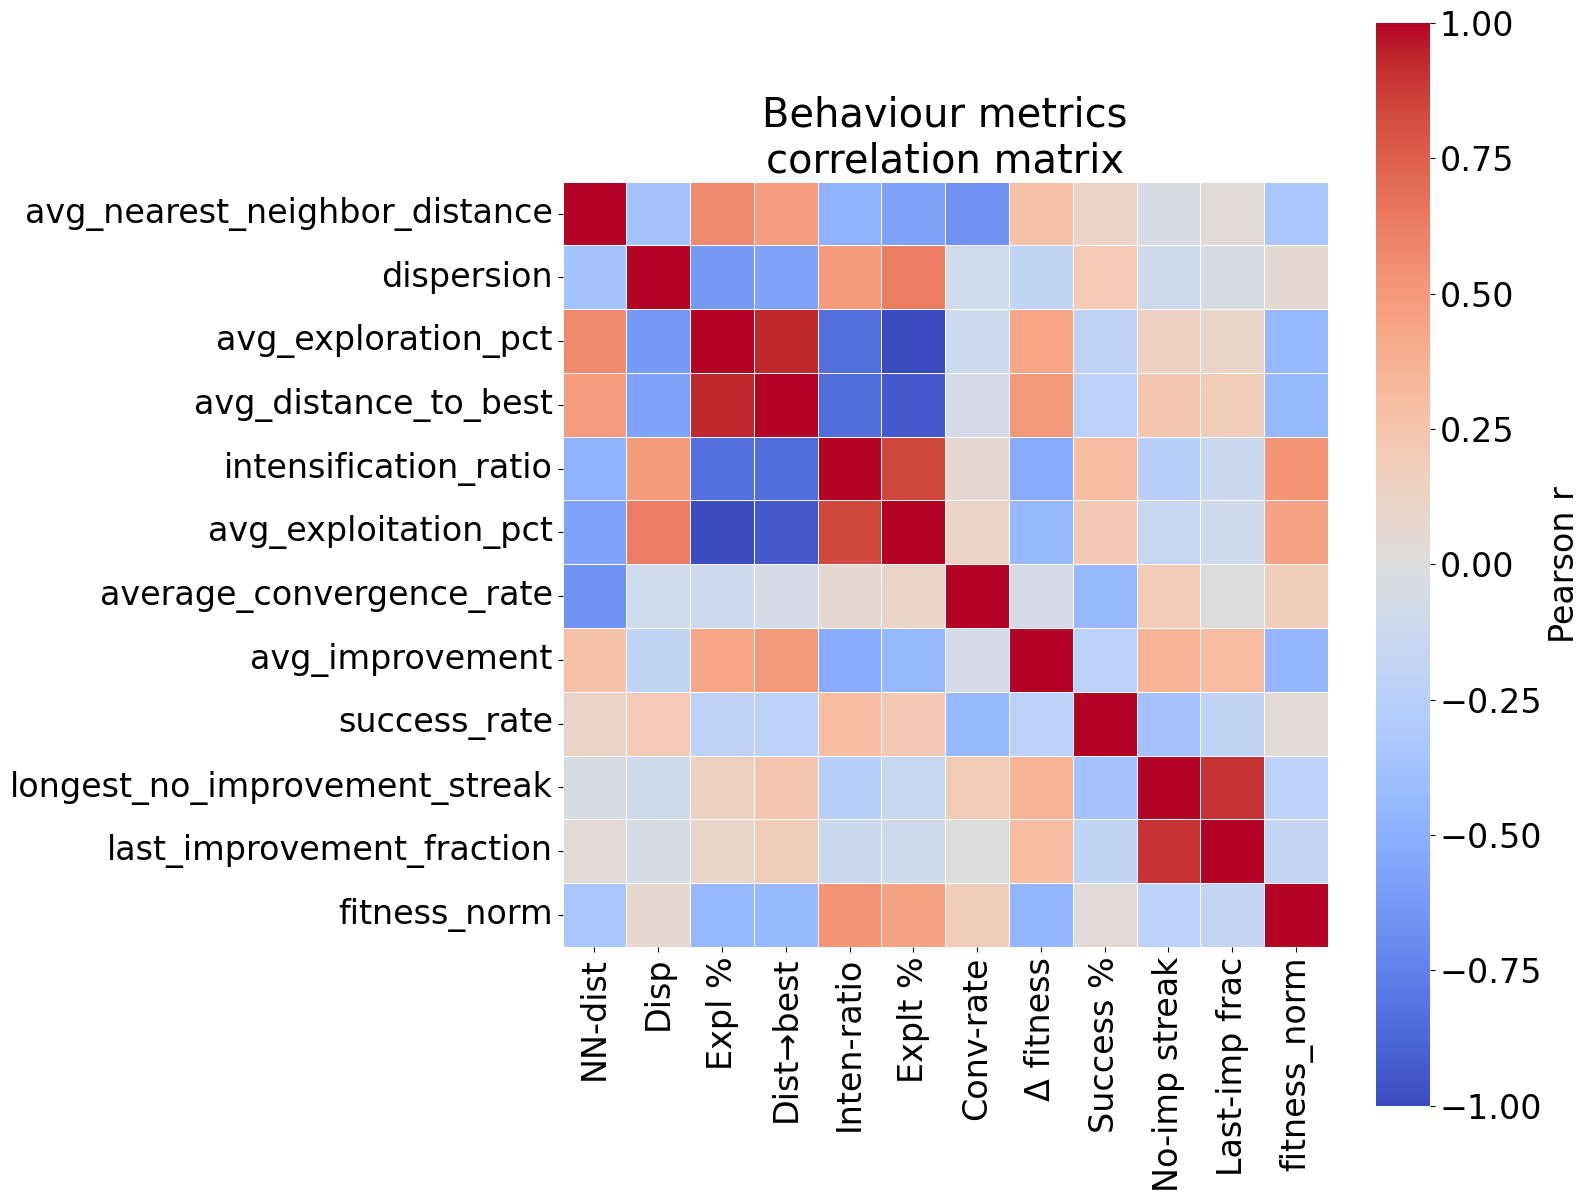

<Figure size 640x480 with 0 Axes>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from pandas.plotting import parallel_coordinates

# ------------------------------------------------------------------
# 0  House‑keeping
# ------------------------------------------------------------------
# Make a copy we can mangle
data = df_all.copy()

# Replace ±∞ with NaN, then drop rows that have no finite fitness at all
data.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
#data = data.dropna(subset=["fitness"])

# Normalise fitness to [0, 1] per algorithm so colour scales are comparable
data["fitness_norm"] = (
    data.groupby("method_name")["fitness_fid"]
        .transform(lambda s: (s - s.min()) / (s.max() - s.min()))
)

# Some columns you’ll want handy later
behaviour_feats = [
    "avg_nearest_neighbor_distance", "dispersion", "avg_exploration_pct",
    "avg_distance_to_best", "intensification_ratio", "avg_exploitation_pct",
    "average_convergence_rate", "avg_improvement", "success_rate",
    "longest_no_improvement_streak", "last_improvement_fraction",
]
nice_names = {
    "avg_nearest_neighbor_distance":  "NN-dist",
    "dispersion":                     "Disp",
    "avg_exploration_pct":            "Expl %",
    "avg_distance_to_best":           "Dist→best",
    "intensification_ratio":          "Inten-ratio",
    "avg_exploitation_pct":           "Explt %",
    "average_convergence_rate":       "Conv-rate",
    "avg_improvement":                "Δ fitness",
    "success_rate":                   "Success %",
    "longest_no_improvement_streak":  "No-imp streak",
    "last_improvement_fraction":      "Last-imp frac",
}

# ------------------------------------------------------------------
# 1  Behaviour features over evaluations
#     (_id is assumed to be monotonically increasing per seed)
# ------------------------------------------------------------------
for algo, g in data.groupby("method_name", sort=False):
    # Pre‑sort once for nicer lines
    g = g.sort_values(["seed", "_id"])

    for feat in behaviour_feats:
        plt.figure(figsize=(8, 4))

        # All individual runs in the background
        for _, seed_group in g.groupby("seed"):
            plt.plot(
                seed_group["_id"],
                seed_group[feat],
                linewidth=0.6,
                alpha=0.3,
            )

        # Mean trend over runs on top
        mean_curve = (
            g.groupby("_id")[feat]
              .mean()
              .reset_index()
              .sort_values("_id")
        )
        plt.plot(
            mean_curve["_id"],
            mean_curve[feat],
            linewidth=2,
            label="per‑eval mean",
        )

        plt.title(f"{algo}")
        plt.xlabel("Evaluations")
        plt.ylabel(feat)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig(f"{img_dir}{algo}_{feat}.png")
        plt.clf()
        plt.close()

# ------------------------------------------------------------------
# 2  All methods in one figure per behaviour feature
# ------------------------------------------------------------------
palette = sns.color_palette("tab10", n_colors=data["method_name"].nunique())

for feat in behaviour_feats:
    plt.figure(figsize=(10, 6))

    # Average each method over seeds at every evaluation step
    mean_per_method = (
        data.groupby(["method_name", "_id"])[feat]
            .median()
            .reset_index()
            .sort_values("_id")
    )

    # One line per algorithm
    for (algo, g), colour in zip(mean_per_method.groupby("method_name", sort=False),
                                palette):
        plt.plot(
            g["_id"],
            g[feat],
            label=algo,
            linewidth=2,
            alpha=0.8,
            color=colour,
        )

    plt.title(f"Median {nice_names.get(feat, feat)}")
    plt.xlabel("Evaluations")
    plt.ylabel(nice_names.get(feat, feat))
    plt.legend(loc="best", frameon=False, fontsize="small")
    plt.tight_layout()
    plt.savefig(f"{img_dir}ALL_{feat}.png")
    plt.clf()
    plt.close()

# ------------------------------------------------------------------
# 1  Correlation heat‑map 
# ------------------------------------------------------------------
#for algo, g in data.groupby("method_name", sort=False):

corr = data[behaviour_feats + ["fitness_norm"]].corr()

plot_df = corr.rename(columns=nice_names)
plt.figure(figsize=(16, 14))
sns.heatmap(
    plot_df,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws=dict(label="Pearson r"),
)
plt.title(f"Behaviour metrics\ncorrelation matrix")
plt.savefig(f"{img_dir}behaviour-metrics-correlation.png")
plt.tight_layout()
plt.show()
plt.clf()
# ------------------------------


# Parallel coordinates for all!
pc = data[behaviour_feats + ["fitness_norm"]].copy()

# 2‑a.  Min‑max scale features (parallel plots hate disparate ranges)
pc[behaviour_feats] = (
    pc[behaviour_feats] - pc[behaviour_feats].min()
) / (pc[behaviour_feats].max() - pc[behaviour_feats].min())

quartile_labels = ["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
quart_cat = pd.CategoricalDtype(categories=quartile_labels, ordered=True)

# 2‑b.  Quartile‑bin fitness so we can colour by performance
pc["fitness_group"] = pd.qcut(
    pc["fitness_norm"], 4, labels=quartile_labels, duplicates="drop"
)
pc["fitness_group"] = pc["fitness_group"].astype(quart_cat)
pc = pc.sort_values("fitness_group", key=lambda s: s.cat.codes)

# ── optional: subsample to keep the plot readable ──────────────
#sample = pc.sample(n=min(len(pc), 600), random_state=42)

fig, ax = plt.subplots(figsize=(16, 12))

plot_df = pc.rename(columns=nice_names)
parallel_coordinates(
    plot_df, "fitness_group", alpha=0.3, linewidth=1.0,
    colormap="seismic", ax=ax,
)

handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, quartile_labels, title="fitness quartile",
#     loc="upper left", frameon=True)
plt.title(f"Behaviour profile")
plt.ylabel("scaled feature value")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.savefig(f"{img_dir}behaviour-pc.png")
plt.clf()
plt.close()

# ------------------------------------------------------------------
# 2  Parallel‑coordinate plot per algorithm
# ------------------------------------------------------------------
for algo, g in data.groupby("method_name", sort=False):

    pc = g[behaviour_feats + ["fitness_norm"]].copy()

    # 2‑a.  Min‑max scale features (parallel plots hate disparate ranges)
    pc[behaviour_feats] = (
        pc[behaviour_feats] - pc[behaviour_feats].min()
    ) / (pc[behaviour_feats].max() - pc[behaviour_feats].min())

    # 2‑b.  Quartile‑bin fitness so we can colour by performance
    pc["fitness_group"] = pd.qcut(
        pc["fitness_norm"], 4, labels=quartile_labels, duplicates="drop" #["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
    )
    pc["fitness_group"] = pc["fitness_group"].astype(quart_cat)

    pc = pc.sort_values("fitness_group", key=lambda s: s.cat.codes)
    # ── optional: subsample to keep the plot readable ──────────────
    #sample = pc.sample(n=min(len(pc), 600), random_state=42)

    plt.figure(figsize=(16, 12))
    parallel_coordinates(
        pc, "fitness_group", alpha=0.4, linewidth=1.0,
        colormap="seismic",
    )
    plt.title(f"{algo} — parallel‑coordinate behaviour profile")
    plt.ylabel("scaled feature value")
    plt.xticks(rotation=90, ha="right")
    plt.tight_layout()
    plt.savefig(f"{img_dir}{algo}_pc.png")
    plt.clf()
    plt.close()


In [9]:
# ------------------------------------------------------------------
# 0  Aggregate the 50 raw auc‑columns into 10 function‑level scores
# ------------------------------------------------------------------



func_ids        = [1, 3, 6, 8, 10, 13, 15, 17, 21, 23]
runs_per_func   = 5          # we know each function has 5 runs
quart_labels    = ["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
quart_cat       = pd.CategoricalDtype(quart_labels, ordered=True)



# ------------------------------------------------------------------
# 1  Build a helper with min‑max‑scaled behaviour features
# ------------------------------------------------------------------
behaviour_feats = [
    "avg_nearest_neighbor_distance", "dispersion", "avg_exploration_pct",
    "avg_distance_to_best", "intensification_ratio", "avg_exploitation_pct",
    "average_convergence_rate", "avg_improvement", "success_rate",
    "longest_no_improvement_streak", "last_improvement_fraction",
]

nice_names = {
    "avg_nearest_neighbor_distance":  "NN-dist",
    "dispersion":                     "Disp",
    "avg_exploration_pct":            "Expl %",
    "avg_distance_to_best":           "Dist→best",
    "intensification_ratio":          "Inten-ratio",
    "avg_exploitation_pct":           "Explt %",
    "average_convergence_rate":       "Conv-rate",
    "avg_improvement":                "Δ fitness",
    "success_rate":                   "Success %",
    "longest_no_improvement_streak":  "No-imp streak",
    "last_improvement_fraction":      "Last-imp frac",
}

data = df.copy()
data[behaviour_feats] = (
    data[behaviour_feats] - data[behaviour_feats].min()
) / (data[behaviour_feats].max() - data[behaviour_feats].min())


# ------------------------------------------------------------------
# 2  Parallel‑coordinate plot for each function‑level AUC
# ------------------------------------------------------------------
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

col = "fitness_fid"
for fid in func_ids:
    num_cols = data.select_dtypes('number').columns          # all numeric columns
    agg_map  = {c: 'mean' for c in num_cols} | {           # mean for numbers
                'method_name': 'first',                    # keep one value
                'problem_name': 'first'}                   #  – they should be constant per id

    df_fid = data[data["fid"] == fid].copy()
    df_f = (df_fid
            .groupby('id', as_index=False)
            .agg(agg_map))


    if df_f.empty:       # nothing to draw for this function
        continue



    # quartile‑bin the aggregated fitness score
    q = pd.qcut(df_f[col], 4, labels=quart_labels).astype(quart_cat)

    # frame to plot: scaled behaviour + quartile label
    plot_df = df_f[behaviour_feats + ["fitness_fid"]].copy()
    plot_df["fitness_quartile"] = q

    # (optional) thin out lines for readability
    #plot_df = plot_df.sample(n=min(len(plot_df), 2000), random_state=42)
    plot_df = plot_df.sort_values("fitness_quartile", key=lambda s: s.cat.codes)

    fig, ax = plt.subplots(figsize=(16, 12))
    
    plot_df = plot_df.rename(columns=nice_names)
    parallel_coordinates(
        plot_df, "fitness_quartile", ax=ax,
        alpha=0.35, linewidth=1.0, colormap="seismic",
    )

    # handles, _ = ax.get_legend_handles_labels()
    # ax.legend(handles, quart_labels, title="fitness quartile",
    #           loc="upper left", frameon=True)

    ax.set_title(f"Behaviour profile for $f_{{{fid}}}$")
    ax.set_ylabel("scaled feature value")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    plt.savefig(f"{img_dir}f{fid}_pc.png")
    plt.clf()
    plt.close()


In [10]:
TOP_K     = 100            # ← change this to whatever "top‑k" you want

# ---------------------------------------------------------------
# 1  Gather top‑k rows per function (by aggregated auc_f*)
# ---------------------------------------------------------------
pieces = []

behaviour_feats = [
    "avg_nearest_neighbor_distance", "dispersion", "avg_exploration_pct",
    "avg_distance_to_best", "intensification_ratio", "avg_exploitation_pct",
    #"average_convergence_rate", "avg_improvement", "success_rate",
    "longest_no_improvement_streak", "last_improvement_fraction",
]
nice_names = {
    "avg_nearest_neighbor_distance":  "NN-dist",
    "dispersion":                     "Disp",
    "avg_exploration_pct":            "Expl %",
    "avg_distance_to_best":           "Dist→best",
    "intensification_ratio":          "Inten-ratio",
    "avg_exploitation_pct":           "Explt %",
#    "average_convergence_rate":       "Conv-rate",
#    "avg_improvement":                "Δ fitness",
#    "success_rate":                   "Success %",
    "longest_no_improvement_streak":  "No-imp streak",
    "last_improvement_fraction":      "Last-imp frac",
}

col = "fitness_fid"
for fid in func_ids:

    df_fid = data[data["fid"] == fid].copy()
    df_f = (df_fid
            .groupby('id', as_index=False)
            .agg(agg_map))

    # take the k rows with highest score for this function
    topk = df_f.nlargest(TOP_K, columns=col)

    # scaled behaviour + fid label
    
    frame = df_f[behaviour_feats + ["fitness_fid"]].loc[topk.index].copy()
    frame["fid"] = f"f{fid}"
    pieces.append(frame)

# Concatenate every function’s Q4 slice
plot_df = pd.concat(pieces, ignore_index=True)

# Rename cols for prettier x‑ticks
plot_df = plot_df.rename(columns=nice_names)

# ------------------------------------------------------------------
# 3  Parallel‑coordinate plot
# ------------------------------------------------------------------
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

# Build a colour list (one per fid) – tab10 has 10 distinct hues
cmap   = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(len(func_ids))]

fig, ax = plt.subplots(figsize=(16, 12))
parallel_coordinates(
    plot_df, "fid",
    ax=ax,
    linewidth=1.1,
    alpha=0.9,
    color=colors,
)

ax.set_title("Top-100 behaviour profiles per function id")
ax.set_ylabel("scaled feature value")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.legend(title="function id", frameon=True, loc="upper left")
fig.tight_layout()
plt.savefig(f"{img_dir}fids_pc.png")
plt.clf()
plt.close()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Plot the converenge curves per problem and then plot the Code Evolution Graphs to inspect different runs of the otpimzers.

plot_convergence(logger, metric="AOCC", save=False, budget=100)
plot_experiment_CEG(logger, save=False, budget=100, max_seeds=10)


In [ ]:
plot_convergence(logger, metric="AOCC", save=True, budget=100)
plot_experiment_CEG(logger, save=True, budget=100, max_seeds=5)

plot_boxplot_fitness(logger)
plot_boxplot_fitness_hue(logger)

In [ ]:

plot_boxplot_fitness(logger)
plot_boxplot_fitness_hue(logger)

table_df = fitness_table(logger, alpha=0.05)
table_df
# Convert to LaTeX; escape=False so we can keep the \textbf{} markup
#latex_str = table_df.to_latex(escape=False)

In [ ]:
import operator

df = manager.load(monotonic=True, include_meta_data=True)

fig, ax = plt.subplots(1,1, figsize=(12,10))
_ = iohinspector.plot.plot_ecdf(df.filter(pl.col("dimension") == 5), y_max=100, y_min=1e-8, ax=ax, scale_xlog=True)
plt.show()

In [ ]:
df_eaf = iohinspector.metrics.transform_fval(df, 1e-8, 1e2)
iohinspector.metrics.get_aocc(df_eaf.filter(pl.col("dimension") == 5), 10000, group_cols=['algorithm_name'])